### Tisya Sharma, DS4200, Homework #5

### Probability Density Estimation (50 points)
#### Part (a)

In [1]:
# Import libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

MLE mean: 24.794117647058822
MLE std: 16.893749995999574


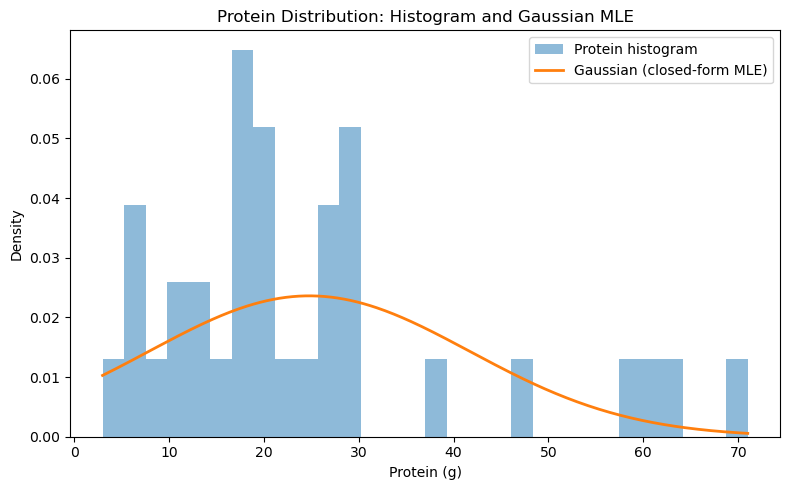

In [2]:
# Load the data
df = pd.read_csv("recipes_df.csv")

# Extract the protein column
x = df["Protein"].dropna().values

# Closed-form MLE for Gaussian N(mu, sigma^2)
# MLE mean: mu_mle = (1/n) * sum x_i
# MLE variance: sigma_mle^2 = (1/n) * sum (x_i - mu_hat)^2

mu_mle = np.mean(x)
sigma_mle = np.std(x, ddof=0)

print("MLE mean:", mu_mle)
print("MLE std:", sigma_mle)

# Plot histogram of data and Gaussian density estimate
plt.figure(figsize=(8, 5))

# Histogram as empirical density
plt.hist(
    x,
    bins=30,
    density=True,
    alpha=0.5,
    label="Protein histogram"
)

# Including an x-grid for smooth PDF curve
xs = np.linspace(x.min(), x.max(), 300)

# Gaussian PDF with MLE parameters
pdf_mle = norm.pdf(xs, loc=mu_mle, scale=sigma_mle)

plt.plot(
    xs,
    pdf_mle,
    linewidth=2,
    label="Gaussian (closed-form MLE)"
)

plt.xlabel("Protein (g)")
plt.ylabel("Density")
plt.title("Protein Distribution: Histogram and Gaussian MLE")
plt.legend()
plt.tight_layout()
plt.show()

#### Part (b)

Closed-form mu: 24.794117647058822
GD mu:          24.793630996456386
Closed-form sigma: 16.893749995999574
GD sigma:          16.89375000303358


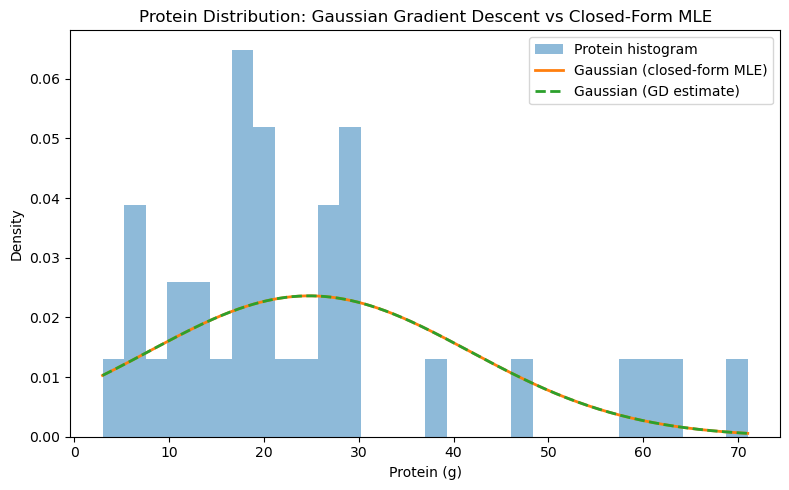

In [3]:
n = len(x)

# Gradient descent on a negative log-likelihood. Here I trym to optimize over mu and s = log(sigma) for stability.
mu = 0.0
# Make sigma = exp(s) start as positive
s = np.log(10.0)        

lr_mu = 1e-3
lr_s = 1e-3
num_iters = 100000

sum_x = np.sum(x)

# Define the gaussian negative log-likelihood (also drop constant 0.5*n*log(2π))
def gaussian_nll(mu, s, x):
    sigma = np.exp(s)
    diff = x - mu
    return n * s + 0.5 * np.sum(diff**2) / (sigma**2)  

for t in range(num_iters):
    sigma = np.exp(s)

    # manual grads of gaussian_nll
    dmu = (1.0 / (sigma**2)) * (n * mu - np.sum(x))
    ds  = n - (1.0 / (sigma**2)) * np.sum((x - mu)**2)

    mu -= lr_mu * dmu
    s  -= lr_s * ds

# Final gradient descent estimates
sigma = np.exp(s)
print("Closed-form mu:", mu_mle)
print("GD mu:", "        ", mu)
print("Closed-form sigma:", sigma_mle)
print("GD sigma:", "        ", sigma)

# Plot histogram and both density curves
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, alpha=0.5, label="Protein histogram")

xs = np.linspace(x.min(), x.max(), 300)
pdf_cf = norm.pdf(xs, loc=mu_mle, scale=sigma_mle)   # closed-form MLE
pdf_gd = norm.pdf(xs, loc=mu, scale=sigma)           # Gradient descent estimate

# Closed-form MLE curve
plt.plot(xs, pdf_cf, color="tab:orange", linewidth=2,
         label="Gaussian (closed-form MLE)")

# GD estimate curve
plt.plot(xs, pdf_gd, "--", color="tab:green", linewidth=2,
         label="Gaussian (GD estimate)")

plt.xlabel("Protein (g)")
plt.ylabel("Density")
plt.title("Protein Distribution: Gaussian Gradient Descent vs Closed-Form MLE")
plt.legend()
plt.tight_layout()
plt.show()


#### Part (c)

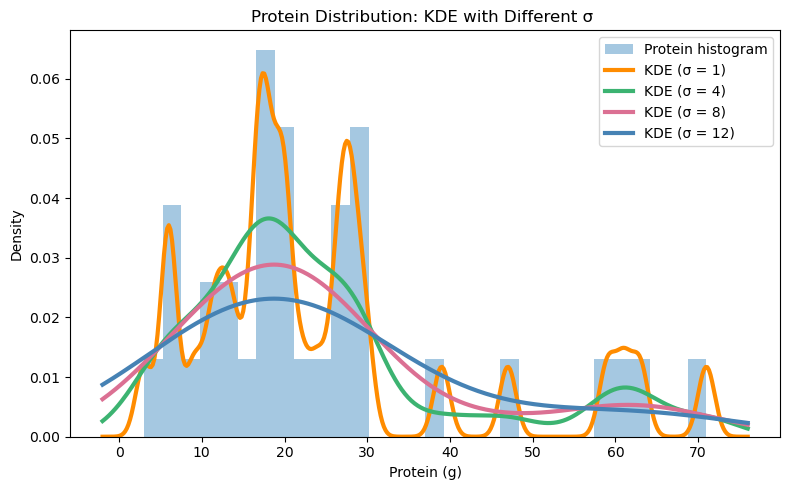

In [4]:
# Gaussian KDE function 
def gaussian_kde(x_eval, data, sigma):
    # x_eval: array of grid points where we evaluate the KDE
    # data:   1D array of samples
    # sigma:  bandwidth parameter
    diffs = x_eval[:, None] - data[None, :]              # shape: (len(x_eval), n)
    kern = np.exp(-0.5 * (diffs / sigma)**2) / (np.sqrt(2*np.pi) * sigma)
    return np.mean(kern, axis=1)                         # (1/n) sum over samples

# Grid for plotting densities
xs = np.linspace(x.min() - 5, x.max() + 5, 400)

sigmas = [1, 4, 8, 12]
colors = ["darkorange", "mediumseagreen", "palevioletred", "steelblue"]

plt.figure(figsize=(8, 5))

# Histogram of data
plt.hist(
    x,
    bins=30,
    density=True,
    alpha=0.4,
    label="Protein histogram"
)

# Plot KDE for different sigma values
for s, c in zip(sigmas, colors):
    kde_vals = gaussian_kde(xs, x, sigma=s)
    plt.plot(xs, kde_vals, color=c, linewidth=3, label=f"KDE (σ = {s})")

plt.xlabel("Protein (g)")
plt.ylabel("Density")
plt.title("Protein Distribution: KDE with Different σ ")
plt.legend()
plt.tight_layout()
plt.show()

#### Part (d)
Out of everything we have tried thus far, I would choose the KDE with σ = 4 as the best overall estimate of the protein distribution. The Gaussian MLE (closed-form and the GD) is restricted to a single symmetric bell shape, but the histogram clearly shows skew and multiple clusters. With this in mind, the Gaussian systematically misallocates probability mass. Among the KDEs, σ = 1 overfits and tracks individual points, while σ = 8 and 12 oversmooth and blur out meaningful modes, essentially underfitting The KDE for σ = 4 gives a smooth, stable curve that still follows the main bumps of the empirical distribution, so it offers the best bias–variance tradeoff for this dataset.